<a href="https://colab.research.google.com/github/gaveter/Project_cs/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Project 2019-20
1. Normalize the loan_lenders table. In the normalized table, each row must have one loan_id and one lender.
2. For each loan, add a column duration corresponding to the number of days between the disburse time and the planned expiration time.
3. Find the lenders that have funded at least twice.
4. For each country, compute how many loans have involved that country as borrowers.
5. For each country, compute the overall amount of money borrowed.
6. Like the previous point, but expressed as a percentage of the overall amount lent.
7. Like the three previous points, but split for each year (with respect to disburse time).
8. For each lender, compute the overall amount of money lent. For each loan that has more than one lender, you must assume that all lenders contributed the same amount.
9. For each country, compute the difference between the overall amount of money lent and the overall amount of money borrowed.
10. Which country has the highest ratio between the difference computed at the previous point and the population?
11. Which country has the highest ratio between the difference computed at point 9 and the population that is not below the poverty line?
12. For each year, compute the total amount of loans. Each loan that has planned expiration time and disburse time in different years must 
have its amount distributed proportionally to the number of days in each year. For example, a loan with disburse time December 1st, 2016,
 planned expiration time January 30th 2018, and amount 5000USD has an amount of 5000USD * 31 / (31+365+30) = 363.85 for 2016, 5000USD * 365 / (31+365+30) = 4284.04
for 2017, and 5000USD * 30 / (31+365+30) = 352.11 for 2018.
© 2019 GitHub, Inc.

## Load libraries

In [3]:
pip install forex-python

     |████████████████████████████████| 92kB 2.6MB/s 
  Created wheel for forex-python: filename=forex_python-1.5-cp36-none-any.whl size=7235 sha256=622e160745389061a060d58b8015f872f16474d3b82223c5c075ccb54d4226c7
  Stored in directory: /root/.cache/pip/wheels/c9/ee/ce/a0c208e72d186b786b0c51914675bc03d1bf00b8ed9406271b
  Created wheel for simplejson: filename=simplejson-3.17.0-cp36-cp36m-linux_x86_64.whl size=114203 sha256=55ace027ec9505198ec496091c71e5c28503a6ed20e6af97fde9566a71e019bc
  Stored in directory: /root/.cache/pip/wheels/86/c0/83/dcd0339abb2640544bb8e0938aab2d069cef55e5647ce6e097
Successfully built forex-python simplejson


In [0]:
import pandas as pd
from datetime import datetime
import re
import numpy as np
import matplotlib.pyplot as plt
import itertools
import functools
import calendar
from collections import defaultdict
from forex_python.converter import CurrencyRates

In [5]:
pip install forex-python

## Task1

### Load csv (loans_lenders)

In [6]:
loans_lender = pd.read_csv('/content/drive/My Drive/Foundation of computer science/additional-kiva-snapshot/loans_lenders.csv')
len(loans_lender)

1387432

In [7]:
loans_lender.head()

,loan_id,lenders
0,483693,"muc888, sam4326, camaran3922, lachheb1865, reb..."
1,483738,"muc888, nora3555, williammanashi, barbara5610,..."
2,485000,"muc888, terrystl, richardandsusan8352, sherri4..."
3,486087,"muc888, james5068, rudi5955, daniel9859, don92..."
4,534428,"muc888, niki3008, teresa9174, mike4896, david7..."


In [0]:
#loans_lender['lengthOriginal']=loans_lender.apply(lambda x: len(x['lenders']),axis=1)

In [0]:
loans_lender["lenders"]=loans_lender["lenders"].str.split(', ') #creazione lista per ogni riga
loans_lender_norm=loans_lender.explode('lenders')

In [10]:
loans_lender_norm.head(10)

,loan_id,lenders
0,483693,muc888
0,483693,sam4326
0,483693,camaran3922
0,483693,lachheb1865
0,483693,rebecca3499
0,483693,karlheinz4543
0,483693,jerrydb
0,483693,paula8951
0,483693,gmct
0,483693,amra9383


### Result

In [11]:
loans_lender_norm=loans_lender_norm.reset_index(drop=True)
loans_lender_norm.head()

,loan_id,lenders
0,483693,muc888
1,483693,sam4326
2,483693,camaran3922
3,483693,lachheb1865
4,483693,rebecca3499


## Task2
- For each loan, add a column duration corresponding to the number of days between the disburse time and the planned expiration time

### Load csv (loans)

In [0]:
loan = pd.read_csv('/content/drive/My Drive/Foundation of computer science/additional-kiva-snapshot/loans.csv')

In [13]:
loan.head()

,loan_id,loan_name,original_language,description,description_translated,funded_amount,loan_amount,status,activity_name,sector_name,loan_use,country_code,country_name,town_name,currency_policy,currency_exchange_coverage_rate,currency,partner_id,posted_time,planned_expiration_time,disburse_time,raised_time,lender_term,num_lenders_total,num_journal_entries,num_bulk_entries,tags,borrower_genders,borrower_pictured,repayment_interval,distribution_model
0,657307,Aivy,English,"Aivy, 21 years of age, is single and lives in ...",NaN,125.0,125.0,funded,General Store,Retail,to buy additional inventories for her sari-sa...,PH,Philippines,Ozamiz - Ozamiz City,shared,0.1,PHP,126.0,2014-01-15 02:23:45.000 +0000,2014-02-14 03:30:06.000 +0000,2013-12-22 08:00:00.000 +0000,2014-01-15 04:48:22.000 +0000,7.0,3,2,1,NaN,female,true,irregular,field_partner
1,657259,Idalia Marizza,Spanish,"Doña Idalia, esta casada, tiene 57 años de eda...","Idalia, 57, is married and lives with her husb...",400.0,400.0,funded,Used Clothing,Clothing,"To buy American clothing such as blouses, shir...",HN,Honduras,"La Lopez, Choloma",shared,0.1,HNL,201.0,2014-01-14 20:23:20.000 +0000,2014-03-26 22:25:07.000 +0000,2013-12-20 08:00:00.000 +0000,2014-02-25 06:42:06.000 +0000,8.0,11,2,1,NaN,female,true,monthly,field_partner
2,658010,Aasia,English,Aasia is a 45-year-old married lady and she ha...,NaN,400.0,400.0,funded,General Store,Retail,"to buy stock of rice, sugar and flour",PK,Pakistan,Lala Musa,shared,0.1,PKR,245.0,2014-01-16 11:32:58.000 +0000,2014-02-15 21:10:05.000 +0000,2014-01-09 08:00:00.000 +0000,2014-01-24 23:06:18.000 +0000,14.0,16,2,1,"#Woman Owned Biz, #Supporting Family, user_fav...",female,true,monthly,field_partner
3,659347,Gulmira,Russian,"Гулмире 36 лет, замужем, вместе с супругом вос...",Gulmira is 36 years old and married. She and ...,625.0,625.0,funded,Farming,Agriculture,"to buy cucumber and tomato seeds, as well as f...",KG,Kyrgyzstan,"Aravan village, Osh region",shared,0.1,KGS,171.0,2014-01-20 09:59:48.000 +0000,2014-02-21 03:10:02.000 +0000,2014-01-17 08:00:00.000 +0000,2014-01-22 05:29:28.000 +0000,14.0,21,2,1,user_favorite,female,true,monthly,field_partner
4,656933,Ricky\t,English,Ricky is a farmer who currently cultivates his...,NaN,425.0,425.0,funded,Farming,Agriculture,to buy organic fertilizer and agrochemical pr...,PH,Philippines,"Baleleng, Sto. Thomas, Isabela",shared,0.1,PHP,123.0,2014-01-14 05:46:21.000 +0000,2014-02-13 06:10:02.000 +0000,2013-12-17 08:00:00.000 +0000,2014-01-14 17:29:27.000 +0000,7.0,15,2,1,"#Animals, #Eco-friendly, #Sustainable Ag",male,true,bullet,field_partner


### Check missing values

In [0]:
missing_loan = pd.isnull(loan[["planned_expiration_time"]])

In [15]:
loan.loc[64:69][["planned_expiration_time","disburse_time"]]

,planned_expiration_time,disburse_time
64,NaN,2010-11-18 08:00:00.000 +0000
65,NaN,2010-11-25 08:00:00.000 +0000
66,NaN,2010-11-25 08:00:00.000 +0000
67,NaN,2010-11-16 08:00:00.000 +0000
68,2016-11-03 06:10:05.000 +0000,2016-09-07 07:00:00.000 +0000
69,NaN,2010-11-10 08:00:00.000 +0000


In [16]:
type(loan.loc[67][["planned_expiration_time"]][0]), type(loan.loc[68][["planned_expiration_time"]][0])

(float, str)

### Conversion attribute 'planned_expiration_time', 'disburse_time' to string

In [0]:
loan["planned_expiration_time"] = loan.apply(lambda x: str(x["planned_expiration_time"]),axis=1) #each row (value is float)
loan["disburse_time"] = loan.apply(lambda x: str(x["disburse_time"]),axis=1)

In [18]:
loan.loc[68]["disburse_time"]

'2016-09-07 07:00:00.000 +0000'

In [0]:
def difference_dates(date1,date2):
  if (date1=="nan" or date2=="nan"):
    return(np.nan) #float
  date1 = date1[:-10] #delete part +0000
  date1 = datetime.strptime(date1,"%Y-%m-%d %H:%M:%S")
  date2 = date2[:-10]
  date2 = datetime.strptime(date2,"%Y-%m-%d %H:%M:%S")
  diff = (date1 - date2).days
  return(diff)

In [0]:
loan["duration"] = loan.apply(lambda x: difference_dates(x["planned_expiration_time"],x["disburse_time"]),axis=1)

In [21]:
zeroDuration = loan[loan["duration"]==0][["planned_expiration_time","disburse_time","duration"]]
len(zeroDuration)

772

### Result

In [22]:
loan.head()[["planned_expiration_time","disburse_time","duration"]]

,planned_expiration_time,disburse_time,duration
0,2014-02-14 03:30:06.000 +0000,2013-12-22 08:00:00.000 +0000,53.0
1,2014-03-26 22:25:07.000 +0000,2013-12-20 08:00:00.000 +0000,96.0
2,2014-02-15 21:10:05.000 +0000,2014-01-09 08:00:00.000 +0000,37.0
3,2014-02-21 03:10:02.000 +0000,2014-01-17 08:00:00.000 +0000,34.0
4,2014-02-13 06:10:02.000 +0000,2013-12-17 08:00:00.000 +0000,57.0


## Task 3
- Find the lenders that have funded at least twice

In [23]:
loan['status'].unique()

array(['funded', 'expired', 'refunded', 'fundRaising'], dtype=object)

In [0]:
fundedLoan=loan[['loan_id','status']]

In [25]:
lenders_funded = pd.merge(loans_lender_norm,fundedLoan,how="inner",on="loan_id")
lenders_funded.head()

,loan_id,lenders,status
0,483693,muc888,funded
1,483693,sam4326,funded
2,483693,camaran3922,funded
3,483693,lachheb1865,funded
4,483693,rebecca3499,funded


In [0]:
numberfunded_lenders = lenders_funded.groupby('lenders')['loan_id'].count().reset_index(level=0)
numberfunded_lenders.columns=['lenders','count']

In [0]:
numberfunded_lenders = numberfunded_lenders[numberfunded_lenders['count']>=2]
numberfunded_lenders = numberfunded_lenders.sort_values('count',ascending=False)

### Result

In [28]:
numberfunded_lenders.head()

,lenders,count
462833,gooddogg1,177645
1324411,trolltech4460,150762
462243,gmct,128159
1008585,nms,104314
1290437,themissionbeltco,81434


## Task 4
- For each country, compute how many loans have involved that country as borrowers.

In [29]:
loan[["country_name","funded_amount","loan_amount","num_lenders_total"]]

,country_name,funded_amount,loan_amount,num_lenders_total
0,Philippines,125.0,125.0,3
1,Honduras,400.0,400.0,11
2,Pakistan,400.0,400.0,16
3,Kyrgyzstan,625.0,625.0,21
4,Philippines,425.0,425.0,15
...,...,...,...,...
1419602,Kenya,400.0,400.0,16
1419603,Philippines,300.0,300.0,12
1419604,Ghana,2425.0,2425.0,76
1419605,Philippines,100.0,100.0,3


In [30]:
loan['status'].unique()

array(['funded', 'expired', 'refunded', 'fundRaising'], dtype=object)

In [0]:
funded=loan[loan['status']=='funded'][['loan_id','country_name','status','currency','funded_amount','loan_amount','num_lenders_total']].head(2)
expired=loan[loan['status']=='expired'][['loan_id','country_name','status','funded_amount','loan_amount','num_lenders_total']].head(2)
refunded=loan[loan['status']=='refunded'][['loan_id','country_name','status','funded_amount','loan_amount','num_lenders_total']].head(2)
fundRaising=loan[loan['status']=='fundRaising'][['loan_id','country_name','status','funded_amount','loan_amount','num_lenders_total']].head(2)

In [32]:
esempio = pd.concat([funded,expired,refunded,fundRaising],axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [33]:
esempio

,country_name,currency,funded_amount,loan_amount,loan_id,num_lenders_total,status
0,Philippines,PHP,125.0,125.0,657307,3,funded
1,Honduras,HNL,400.0,400.0,657259,11,funded
22,Philippines,NaN,100.0,225.0,957461,4,expired
25,Philippines,NaN,225.0,300.0,959145,6,expired
361,Kenya,NaN,0.0,800.0,1158634,0,refunded
1420,Mexico,NaN,2075.0,2625.0,662566,67,refunded
5067,Ghana,NaN,0.0,225.0,1444070,0,fundRaising
16167,Lebanon,NaN,1375.0,2100.0,1431627,53,fundRaising


In [34]:
loan["status"].unique()

array(['funded', 'expired', 'refunded', 'fundRaising'], dtype=object)

### Check missing values

In [35]:
missing = pd.isnull(loan[['country_name']])
missing[missing['country_name']==True]

,country_name


In [0]:
country_numberLoan = loan.groupby('country_name')['status'].count()
country_numberLoan = country_numberLoan.sort_values(ascending=False)

### Result

In [37]:
country_numberLoan.head()

country_name
Philippines    285336
Kenya          143699
Peru            86000
Cambodia        79701
El Salvador     64037
Name: status, dtype: int64

## Task 5
- For each country, compute the overall amount of money borrowed.

In [0]:
country_amountLoan = loan.groupby('country_name')['funded_amount'].sum()
country_amountLoan = country_amountLoan.sort_values(ascending=False)

### Result

In [39]:
country_amountLoan.head()

country_name
Philippines    97045925.0
Peru           78702800.0
Kenya          63650255.0
Paraguay       53715200.0
Cambodia       50829425.0
Name: funded_amount, dtype: float64

## Task 6
- Like the previous point, but expressed as a percentage of the overall amount lent.

In [0]:
country_amountLoan_perc=pd.DataFrame(country_amountLoan).reset_index(level=0)
country_amountLoan_perc.columns=['country','total']

In [41]:
total_lent=country_amountLoan_perc['total'].sum()
total_lent

1130185170.0

In [0]:
country_amountLoan_perc['percentage']=round(country_amountLoan_perc['total']/total_lent*100,2)

In [0]:
country_amountLoan_perc.columns=['country','borrowed','percentage']

### Result

In [44]:
country_amountLoan_perc.head()

,country,borrowed,percentage
0,Philippines,97045925.0,8.59
1,Peru,78702800.0,6.96
2,Kenya,63650255.0,5.63
3,Paraguay,53715200.0,4.75
4,Cambodia,50829425.0,4.50


## Task 7
- Like the three previous points, but split for each year (with respect to disburse time).

In [0]:
global loanYear

In [0]:
loanYear = loan[['loan_id','country_name','disburse_time','planned_expiration_time','duration',
                 'funded_amount','loan_amount','currency']]

In [47]:
missing = pd.isnull(loanYear[['disburse_time']])
missing[missing['disburse_time']==True]

,disburse_time


In [48]:
len(loanYear[loanYear['disburse_time']=="nan"])

2813

In [0]:
loanYear = loanYear[loanYear['disburse_time']!='nan']

In [50]:
inizio=datetime.now()
print("Inizio: "+inizio.strftime("%H:%M:%S"))
loanYear['year']=loanYear.apply(lambda x: int(x["disburse_time"].split('-')[0]),axis=1)
fine=datetime.now()
print("Fine: "+fine.strftime("%H:%M:%S"))
diff= fine - inizio
diff

Inizio: 16:24:08
Fine: 16:24:31


datetime.timedelta(0, 22, 810928)

In [0]:
countryAmount_year=loanYear.groupby(['country_name','year'])['funded_amount'].sum()
countryAmount_year = pd.DataFrame(countryAmount_year)

### Result

In [52]:
countryAmount_year.head()

funded_amount
country_name year               
Afghanistan  2007       194975.0
             2008       365375.0
             2009       581825.0
             2010       563350.0
             2011       245125.0

## Task 8
- For each lender, compute the overall amount of money lent. For each loan that has more than one lender, you must assume that all lenders contributed the same amount.

In [53]:
numberLoans_lender_norm=loans_lender_norm.groupby('loan_id')['lenders'].count()
numberLoans_lender_norm=pd.DataFrame(numberLoans_lender_norm).reset_index(level=0)
numberLoans_lender_norm

,loan_id,lenders
0,84,3
1,85,2
2,86,3
3,88,3
4,89,4
...,...,...
1387427,1444051,1
1387428,1444053,1
1387429,1444058,1
1387430,1444063,1


In [0]:
loans_lender = loan[['loan_id','num_lenders_total','funded_amount']]

In [55]:
numberLoans = pd.merge(loans_lender,numberLoans_lender_norm,how="inner",on="loan_id")
numberLoans.head()

,loan_id,num_lenders_total,funded_amount,lenders
0,657307,3,125.0,3
1,657259,11,400.0,7
2,658010,16,400.0,14
3,659347,21,625.0,17
4,656933,15,425.0,14


In [0]:
correct = numberLoans[numberLoans['num_lenders_total']==numberLoans['lenders']]
wrong = numberLoans[numberLoans['num_lenders_total']!=numberLoans['lenders']]

In [57]:
wrong.head()

,loan_id,num_lenders_total,funded_amount,lenders
1,657259,11,400.0,7
2,658010,16,400.0,14
3,659347,21,625.0,17
4,656933,15,425.0,14
5,659605,13,350.0,14


In [58]:
#plot barchart da fare
print("Info giuste: "+str(len(correct)/len(numberLoans)))
print("Info sbagliate: "+str(len(wrong)/len(numberLoans)))

Info giuste: 0.1917209397532701
Info sbagliate: 0.8082790602467299


In [0]:
loans_lender_correct = pd.merge(loans_lender,numberLoans_lender_norm,how='inner',on='loan_id')
loans_lender_correct.drop(columns='num_lenders_total',inplace=True)

In [0]:
loans_lender_correct['amount']=round(loans_lender_correct['funded_amount']/loans_lender_correct['lenders'],2)

In [61]:
loans_lender_correct.head()

,loan_id,funded_amount,lenders,amount
0,657307,125.0,3,41.67
1,657259,400.0,7,57.14
2,658010,400.0,14,28.57
3,659347,625.0,17,36.76
4,656933,425.0,14,30.36


In [0]:
amount_loan_lender = pd.merge(loans_lender_norm,loans_lender_correct,how="inner",on='loan_id')
amount_loan_lender.drop(columns=['funded_amount','lenders_y'],inplace=True)
amount_loan_lender.columns=['loan_id','lenders','amount'] 

In [0]:
amountLender = amount_loan_lender.groupby('lenders')['amount'].sum()
amountLender = pd.DataFrame(amountLender).reset_index(level=0)

In [0]:
amountLender = amountLender.sort_values(by='amount',ascending=False)

In [0]:
amountLender['amountFormat']=amountLender.apply(lambda x: format(x['amount'],'f'),axis=1)

### Result

In [66]:
amountLender.head()

,lenders,amount,amountFormat
462833,gooddogg1,8.140636e+06,8140636.400000
1324411,trolltech4460,5.634790e+06,5634789.740000
1008585,nms,4.453638e+06,4453638.040000
462243,gmct,4.445122e+06,4445122.169999
158450,bob4739,4.439756e+06,4439755.910000


## Task 9
- For each country, compute the difference between the overall amount of money lent and the overall amount of money borrowed. Since the country of the lender is often unknown, you can assume that the true distribution among the countries is the same as the one computed from the rows where the country is known.

### Load 2 csv: lenders and country_stats

In [0]:
lenders = pd.read_csv('/content/drive/My Drive/Foundation of computer science/additional-kiva-snapshot/lenders.csv')

In [0]:
country_info=pd.read_csv('/content/drive/My Drive/Foundation of computer science/additional-kiva-snapshot/country_stats.csv')

In [0]:
country_info_9 = country_info[['country_name','country_code']] #population is included because it needed for the 10 task

In [0]:
lenders = lenders[['permanent_name','country_code']]

In [0]:
lenders['country_code']=lenders.apply(lambda x: str(x['country_code']),axis=1)

In [72]:
lenders['country_code'].unique()

array(['nan', 'US', 'IN', 'AU', 'PL', 'BR', 'CN', 'FR', 'BG', 'AT', 'GB',
       'ES', 'DE', 'BE', 'SK', 'IT', 'SE', 'JP', 'PK', 'LA', 'AR', 'HU',
       'TR', 'LV', 'TW', 'MY', 'NL', 'GE', 'ID', 'RU', 'CA', 'PT', 'NG',
       'IS', 'NO', 'HK', 'JO', 'KE', 'MT', 'VN', 'CH', 'NZ', 'FI', 'MX',
       'TN', 'CO', 'AE', 'KR', 'DK', 'TZ', 'PH', 'GR', 'RO', 'CR', 'IL',
       'SA', 'GH', 'PR', 'VE', 'LK', 'EG', 'MA', 'TH', 'AM', 'PG', 'CZ',
       'SG', 'CL', 'YE', 'CY', 'PY', 'HR', 'MN', 'CM', 'UG', 'LT', 'EE',
       'BH', 'DZ', 'IE', 'RS', 'KY', 'IR', 'GT', 'DO', 'PS', 'PE', 'BD',
       'ET', 'SY', 'UY', 'RW', 'AS', 'PA', 'AL', 'UA', 'EC', 'KW', 'AD',
       'NI', 'ZA', 'MM', 'FJ', 'LC', 'IQ', 'HT', 'AO', 'SD', 'SI', 'MK',
       'OM', 'AQ', 'LY', 'AZ', 'AF', 'MO', 'BS', 'MZ', 'SV', 'ZM', 'LU',
       'HN', 'BI', 'BJ', 'YT', 'GU', 'ML', 'BO', 'GW', 'TJ', 'KH', 'SR',
       'LB', 'VU', 'AN', 'MP', 'MW', 'QA', 'MH', 'TM', 'UM', 'SZ', 'XK',
       'NE', 'TT', 'SO', 'ZW', 'TK', 'BB', 'JM', '

In [0]:
totale = len(lenders)
sconosciuti = len(lenders[lenders['country_code']=='nan'])

In [74]:
print("Country lenders not known: "+str(sconosciuti/totale))

Country lenders not known: 0.620913989342637


In [75]:
country_info

,country_name,country_code,country_code3,continent,region,population,population_below_poverty_line,hdi,life_expectancy,expected_years_of_schooling,mean_years_of_schooling,gni,kiva_country_name
0,India,IN,IND,Asia,Southern Asia,1339180127,21.9,0.623559,68.322,11.696590,6.298834,5663.474799,India
1,Nigeria,NG,NGA,Africa,Western Africa,190886311,70.0,0.527105,53.057,9.970482,6.000000,5442.901264,Nigeria
2,Mexico,MX,MEX,Americas,Central America,129163276,46.2,0.761683,76.972,13.299090,8.554985,16383.106680,Mexico
3,Pakistan,PK,PAK,Asia,Southern Asia,197015955,29.5,0.550354,66.365,8.106910,5.089460,5031.173074,Pakistan
4,Bangladesh,BD,BGD,Asia,Southern Asia,164669751,31.5,0.578824,71.985,10.178706,5.241577,3341.490722,Bangladesh
...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,Somalia,SO,SOM,Africa,Eastern Africa,14742523,NaN,NaN,NaN,NaN,NaN,NaN,Somalia
170,Central African Republic,CF,CAF,Africa,Middle Africa,4659080,NaN,0.352440,51.458,7.098980,4.230000,587.473961,Central African Republic
171,Samoa,WS,WSM,Oceania,Polynesia,196440,NaN,0.702000,NaN,NaN,NaN,NaN,Samoa
172,Palestine,PS,PS,Asia,Western Asia,4920724,NaN,0.677000,NaN,NaN,NaN,NaN,Palestine


In [0]:
lenders_country = pd.merge(lenders,country_info_9,how='left',on='country_code')
lenders_country.drop(columns='country_code',inplace=True)

In [0]:
lenders_country['country_name'] = lenders_country.apply(lambda x: str(x['country_name']),axis=1)

In [78]:
lenders_country.head()

,permanent_name,country_name
0,qian3013,nan
1,reena6733,nan
2,mai5982,nan
3,andrew86079135,nan
4,nguyen6962,nan


In [0]:
lenders_country.columns=['lenders','country_name']

In [0]:
lenders_country_distTrovati = lenders_country[lenders_country['country_name']!='nan']

In [0]:
lenders_country_distTrovare = lenders_country[lenders_country['country_name']=='nan']

In [0]:
lenders_country_dist = lenders_country_distTrovati.groupby('country_name')['lenders'].count()
lenders_country_dist = pd.DataFrame(lenders_country_dist).reset_index(level=0)

In [83]:
number_lenders = lenders_country_dist['lenders'].sum()
number_lenders

888056

<BarContainer object of 170 artists>

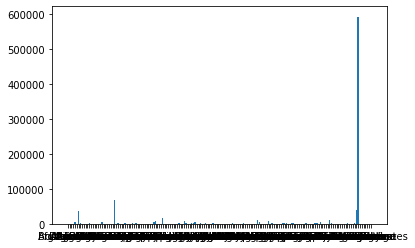

In [84]:
fig = plt.figure()
plt.bar(lenders_country_dist['country_name'],lenders_country_dist['lenders'])

In [0]:
lenders_country_dist['distribution'] = lenders_country_dist['lenders'] / number_lenders

In [0]:
dist= lenders_country_dist.sort_values(by='lenders',ascending=False)

In [87]:
dist

,country_name,lenders,distribution
162,United States,591612,0.666188
26,Canada,67970,0.076538
161,United Kingdom,38380,0.043218
6,Australia,37103,0.041780
53,Germany,16007,0.018025
...,...,...,...
157,Turkmenistan,4,0.000005
44,Eritrea,4,0.000005
96,Mauritania,4,0.000005
30,Comoros,1,0.000001


Text(0, 0.5, 'percentage')

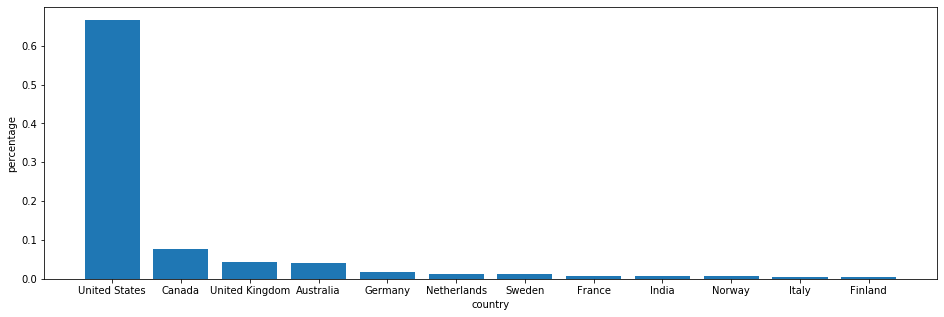

In [88]:
dist_focus = dist[dist['distribution']>0.005]
fig = plt.figure(figsize=(16,5))
plt.bar(dist_focus['country_name'],dist_focus['distribution'])
plt.xlabel('country')
plt.ylabel('percentage')

In [89]:
lenders_country_distTrovare.head()

,lenders,country_name
0,qian3013,nan
1,reena6733,nan
2,mai5982,nan
3,andrew86079135,nan
4,nguyen6962,nan


In [90]:
dist['numberRecord']=round(dist['distribution']*len(lenders_country_distTrovare),0)
dist['numberRecord'] = dist.apply(lambda x: int(x['numberRecord']),axis=1)
dist

,country_name,lenders,distribution,numberRecord
162,United States,591612,0.666188,973379
26,Canada,67970,0.076538,111831
161,United Kingdom,38380,0.043218,63147
6,Australia,37103,0.041780,61046
53,Germany,16007,0.018025,26336
...,...,...,...,...
157,Turkmenistan,4,0.000005,7
44,Eritrea,4,0.000005,7
96,Mauritania,4,0.000005,7
30,Comoros,1,0.000001,2


In [0]:
dist['countryLender']=dist.apply(lambda x: [x['country_name']]*x['numberRecord'],axis=1)

In [0]:
country_lenderTrovare = pd.Series.to_list(dist['countryLender']) #concat all list for each country

In [0]:
country_lenderTrovare = list(itertools.chain(*country_lenderTrovare)) #flat list
country_lenderTrovare = country_lenderTrovare[:-2]

In [94]:
lenders_country_distTrovare['country_name']=country_lenderTrovare

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
lenders_country = pd.concat([lenders_country_distTrovare,lenders_country_distTrovati],axis=0)

In [96]:
lenders_country

,lenders,country_name
0,qian3013,United States
1,reena6733,United States
2,mai5982,United States
3,andrew86079135,United States
4,nguyen6962,United States
...,...,...
2349158,rakhi,United States
2349159,vicki5374,United States
2349161,jennifer5879,Canada
2349171,maria2141,United States


In [0]:
amount_lender_country = pd.merge(amountLender,lenders_country,how='inner',on='lenders')

In [0]:
country_amountLent = amount_lender_country.groupby('country_name')['amount'].sum()

In [0]:
country_amountLent = pd.DataFrame(country_amountLent).reset_index(level=0)

In [100]:
country_amountLent.head()

,country_name,amount
0,Afghanistan,161266.34
1,Albania,53739.63
2,Algeria,152502.87
3,Angola,46443.26
4,Argentina,2796947.51


In [0]:
country_amountLent.columns=['country','lent']

In [102]:
country_amountLoan_perc.columns

Index(['country', 'borrowed', 'percentage'], dtype='object')

In [0]:
country_difference = pd.merge(country_amountLoan_perc,country_amountLent,how='inner',on='country')
country_difference.drop(columns='percentage',inplace=True)

In [0]:
country_difference['difference'] = country_difference['lent'] - country_difference['borrowed']

### Result

In [105]:
country_difference.head()

,country,borrowed,lent,difference
0,Philippines,97045925.0,3190391.83,-93855533.17
1,Peru,78702800.0,210138.88,-78492661.12
2,Kenya,63650255.0,619401.25,-63030853.75
3,Paraguay,53715200.0,66041.90,-53649158.10
4,Cambodia,50829425.0,211303.13,-50618121.87


## Task 10
- Which country has the highest ratio between the difference computed at the previous point and the population?

In [0]:
country_info_10 = country_info[['country_name','population']]

In [0]:
country_difference = pd.merge(country_difference,country_info_10,how='inner',left_on='country',right_on='country_name')

In [0]:
country_difference.drop(columns='country_name',inplace=True)

In [0]:
country_difference['ratio']= country_difference['difference'] / country_difference['population']

In [0]:
highest_ratio = country_difference.sort_values(by='ratio',ascending=False)

### Result

In [111]:
print("Country highest ratio: "+highest_ratio.iloc[0]['country'])

Country highest ratio: Canada


## Task 11
- Which country has the highest ratio between the difference computed at point 9 and the population that is not below the poverty line?

In [0]:
country_info_11=country_info[['country_name','population','population_below_poverty_line']]

In [113]:
media = country_info_11['population_below_poverty_line'].mean()
media

28.47697368421052

In [114]:
country_info_11[country_info_11['population_below_poverty_line']> media]['country_name'].unique()

array(['Nigeria', 'Mexico', 'Pakistan', 'Bangladesh',
       'Democratic Republic of the Congo', 'Ethiopia', 'Kenya', 'Sudan',
       'Madagascar', 'Italy', 'Yemen', 'Syria', 'Argentina', 'Mozambique',
       'Afghanistan', 'Angola', 'Zimbabwe', 'Ivory Coast', 'Zambia',
       'Guatemala', 'Niger', 'Malawi', 'Burkina Faso', 'Senegal',
       'Cameroon', 'Burundi', 'Chad', 'Mali', 'Haiti', 'South Sudan',
       'Guinea', 'Sierra Leone', 'Rwanda', 'Togo', 'Bolivia', 'Benin',
       'Greece', 'Dominican Republic', 'Papua New Guinea', 'Tajikistan',
       'Honduras', 'Liberia', 'Eritrea', 'Congo', 'El Salvador', 'Libya',
       'Kyrgyzstan', 'Nicaragua', 'Lebanon', 'Mauritania', 'Lesotho',
       'Guinea-Bissau', 'Gambia', 'Armenia', 'Swaziland', 'Namibia',
       'Gabon', 'Botswana', 'Equatorial Guinea', 'Timor-Leste',
       'Suriname', 'Comoros', 'Fiji', 'Guyana', 'Belize', 'Kosovo'],
      dtype=object)

In [115]:
country_info_11[country_info_11['population_below_poverty_line']> 50]['country_name'].unique()

array(['Nigeria', 'Democratic Republic of the Congo', 'Madagascar',
       'Yemen', 'Syria', 'Zimbabwe', 'Zambia', 'Guatemala', 'Malawi',
       'Burundi', 'Haiti', 'South Sudan', 'Sierra Leone', 'Togo',
       'Liberia', 'Lesotho', 'Guinea-Bissau', 'Swaziland', 'Suriname'],
      dtype=object)

In [0]:
valori = country_info_11['population_below_poverty_line']

In [0]:
valori = pd.DataFrame(valori)
valori = valori.dropna()

In [118]:
quantili = valori.population_below_poverty_line.quantile([0.25,0.5,0.75])
first_quantile=quantili.iloc[0]
third_quantile=quantili.iloc[2]
quantili

0.25    15.100
0.50    23.000
0.75    38.725
Name: population_below_poverty_line, dtype: float64

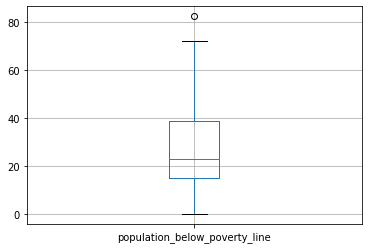

In [119]:
valori.boxplot(column='population_below_poverty_line')

Text(0.5, 1.0, 'Distribution poverty line')

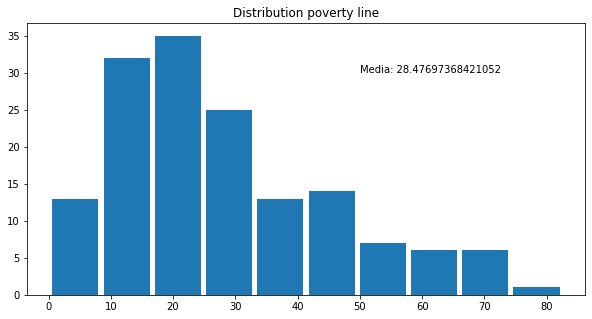

In [120]:
stringa='Media: '+str(media)

fig = plt.figure(figsize=(10,5))
plt.hist(valori['population_below_poverty_line'],bins='auto',rwidth=0.9)
plt.text(50, 30, stringa)
plt.title("Distribution poverty line")

In [0]:
country_info_11 = country_info_11[country_info_11['population_below_poverty_line']<50]

In [0]:
country_difference_ratio = pd.merge(country_difference,country_info_11,how='inner',left_on='country',right_on='country_name')

In [0]:
country_difference_ratio.drop(columns=['country_name','population_y'],inplace=True)

In [124]:
country_difference_ratio

,country,borrowed,lent,difference,population_x,ratio,population_below_poverty_line
0,Philippines,97045925.0,3190391.83,-93855533.17,104918090,-0.894560,21.6
1,Peru,78702800.0,210138.88,-78492661.12,32165485,-2.440276,22.7
2,Kenya,63650255.0,619401.25,-63030853.75,49699862,-1.268230,43.4
3,Paraguay,53715200.0,66041.90,-53649158.10,6811297,-7.876497,22.2
4,Cambodia,50829425.0,211303.13,-50618121.87,16005373,-3.162571,17.7
...,...,...,...,...,...,...,...
59,Papua New Guinea,50000.0,12728.95,-37271.05,8251162,-0.004517,37.0
60,Bhutan,15625.0,3205.37,-12419.63,807610,-0.015378,13.3
61,Mauritania,15000.0,269.49,-14730.51,4420184,-0.003333,31.0
62,Botswana,8000.0,23897.32,15897.32,2291661,0.006937,30.3


### Result

In [125]:
highest_ratio_notPoverty = country_difference_ratio.sort_values(by='ratio',ascending=False)
print("Country highest ratio with constraint: "+highest_ratio.iloc[0]['country'])

Country highest ratio with constraint: Canada


## Task 12
- For each year, compute the total amount of loans. Each loan that has planned expiration time and disburse time in different years must have its amount distributed proportionally to the number of days in each year. For example, a loan with disburse time December 1st, 2016, planned expiration time January 30th 2018, and amount 5000USD has an amount of 5000USD * 31 / (31+365+30) = 363.85 for 2016, 5000USD * 365 / (31+365+30) = 4284.04 for 2017, and 5000USD * 30 / (31+365+30) = 352.11 for 2018.

In [0]:
loanYear.columns = ['loan_id','country','disburse_time','planned_expiration_time','duration',
                    'funded_amount','loan_amount','currency','year_disburse']

In [0]:
loanYear = loanYear[loanYear['duration']>0]

In [0]:
loanYear['currency'] = loanYear.apply(lambda x: str(x['currency']),axis=1)

In [129]:
loanYear['currency'].unique()

array(['PHP', 'HNL', 'PKR', 'KGS', 'USD', 'BIF', 'XOF', 'MNT', 'PEN',
       'AMD', 'GHS', 'TZS', 'GTQ', 'PYG', 'NIO', 'KES', 'UGX', 'RWF',
       'MZN', 'AZN', 'ILS', 'TJS', 'MXN', 'IDR', 'MGA', 'BOB', 'VND',
       'COP', 'JOD', 'YER', 'INR', 'CLP', 'KHR', 'ALL', 'NPR', 'SLL',
       'LBP', 'XAF', 'WST', 'DOP', 'LRD', 'LAK', 'MMK', 'GEL', 'HTG',
       'UAH', 'EUR', 'ZAR', 'SDG', 'CRC', 'TRY', 'EGP', 'ZMW', 'ZMK',
       'BZD', 'MWK', 'SRD', 'SSP', 'NGN', 'SBD', 'MDL', 'CNY', 'BRL',
       'LSL', 'THB', 'NAD', 'VUV', 'XCD', 'ZWD'], dtype=object)

### Conversion amount loan from change country to USD

In [0]:
global currency_list

In [0]:
currency_object = CurrencyRates()
currency_list = currency_object.get_rates('USD')

In [0]:
'''def conversion_toUSD(currency, amount, date):
  currency_result = currency_object.convert(currency,'USD',amount,date)
  return round(currency_result,2)'''

In [132]:
loanYear.head()

,loan_id,country,disburse_time,planned_expiration_time,duration,funded_amount,loan_amount,currency,year_disburse
0,657307,Philippines,2013-12-22 08:00:00.000 +0000,2014-02-14 03:30:06.000 +0000,53.0,125.0,125.0,PHP,2013
1,657259,Honduras,2013-12-20 08:00:00.000 +0000,2014-03-26 22:25:07.000 +0000,96.0,400.0,400.0,HNL,2013
2,658010,Pakistan,2014-01-09 08:00:00.000 +0000,2014-02-15 21:10:05.000 +0000,37.0,400.0,400.0,PKR,2014
3,659347,Kyrgyzstan,2014-01-17 08:00:00.000 +0000,2014-02-21 03:10:02.000 +0000,34.0,625.0,625.0,KGS,2014
4,656933,Philippines,2013-12-17 08:00:00.000 +0000,2014-02-13 06:10:02.000 +0000,57.0,425.0,425.0,PHP,2013


In [0]:
loanYear['disburse_time'] = loanYear.apply(lambda x: datetime.strptime(x['disburse_time'][:-10],"%Y-%m-%d %H:%M:%S"),axis=1)

In [0]:
loanYear['planned_expiration_time'] = loanYear.apply(lambda x: datetime.strptime(x['planned_expiration_time'][:-10],"%Y-%m-%d %H:%M:%S"),axis=1)

In [135]:
loanYear.head()

,loan_id,country,disburse_time,planned_expiration_time,duration,funded_amount,loan_amount,currency,year_disburse
0,657307,Philippines,2013-12-22 08:00:00,2014-02-14 03:30:06,53.0,125.0,125.0,PHP,2013
1,657259,Honduras,2013-12-20 08:00:00,2014-03-26 22:25:07,96.0,400.0,400.0,HNL,2013
2,658010,Pakistan,2014-01-09 08:00:00,2014-02-15 21:10:05,37.0,400.0,400.0,PKR,2014
3,659347,Kyrgyzstan,2014-01-17 08:00:00,2014-02-21 03:10:02,34.0,625.0,625.0,KGS,2014
4,656933,Philippines,2013-12-17 08:00:00,2014-02-13 06:10:02,57.0,425.0,425.0,PHP,2013


In [0]:
currency_included = pd.DataFrame(loanYear['currency'].unique())
currency_included.columns=['currency']

In [0]:
def check_currency(currency):
  if currency not in currency_list or currency=='USD':
    conv = False
  else:
    conv = True
  return conv

In [0]:
currency_included['conversion'] = currency_included.apply(lambda x: check_currency(x['currency']),axis=1)

In [139]:
currency_included.head()

,currency,conversion
0,PHP,True
1,HNL,False
2,PKR,False
3,KGS,False
4,USD,False


In [0]:
loanYear = pd.merge(loanYear,currency_included,how='inner',on='currency')

In [0]:
firstBlock = loanYear[loanYear['conversion']==True]
secondBlock = loanYear[loanYear['conversion']==False]

In [142]:
len(firstBlock), len(secondBlock)

(271075, 758180)

In [143]:
secondBlock['loan_amount_conversion'] = secondBlock['loan_amount']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [144]:
secondBlock.drop(columns=['conversion'],inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [145]:
firstBlock.groupby('currency')['country'].count()

currency
BRL       462
CNY       125
EUR      2180
IDR      7862
ILS       371
INR     14707
MXN      9375
PHP    233833
THB        50
TRY      1974
ZAR       136
Name: country, dtype: int64

In [146]:
currency_firstBlock = firstBlock['currency'].unique()
currency_firstBlock

array(['PHP', 'ILS', 'MXN', 'IDR', 'INR', 'EUR', 'ZAR', 'TRY', 'CNY',
       'BRL', 'THB'], dtype=object)

In [0]:
currency_firstBlock[7:9]

array(['TRY', 'CNY'], dtype=object)

In [0]:
firstBlock_test=firstBlock[firstBlock['currency'].isin(currency_firstBlock)]

#firstBlock_test=firstBlock[firstBlock['currency'].isin(currency_firstBlock)]

In [0]:
dateCurrency = firstBlock_test[['loan_id','disburse_time','currency']]

In [0]:
val = range(len(currency_firstBlock))
assignment = list(map(lambda x,y: (x,y),currency_firstBlock, val))
index_currency = pd.DataFrame(assignment)
index_currency.columns=['currency','index_currency']

firstBlock_test = pd.merge(firstBlock_test,index_currency,how='inner',on='currency')

In [0]:
''''curr = list(map(lambda x: x[0], assignment))
index = list(map(lambda x: x[1], assignment))

dict_currency = dict(zip(index, curr))''''

In [0]:
#assignment[7:9] , dict_currency

In [0]:
def create_dictionary_currency(list_dict):
  dates_dict = defaultdict(list)
  for key, info in list_dict:
    #print(key, info)
    dates_dict[key].append(info)
  return dates_dict

In [0]:
'''def fill_list(currency, dates):
  date_list=list()
  for key in dates:
    currency_rate = (currency,currency_object.get_rate(currency,'USD',key))
    pair = (key,currency_rate)
    date_list.append(pair)
  print("Trovato rate currency "+str(currency))
  return date_list

def controllaPerformance(firstBlock_test,currency_list):
  currency_list = dateCurrency['currency'].unique()
  dict_currency_list = list()
  for i in currency_list:
    print(i)
    loan_currency = firstBlock_test[firstBlock_test['currency']==i][['disburse_time','currency']]
    date_loan_currency = set(loan_currency['disburse_time'].tolist()) #drop duplicates
    ris = fill_list(i,date_loan_currency)
    #print(ris)
    dict_currency_list.append(ris)

  return dict_currency_list'''

In [0]:
def get_rate_currency(currency, date):
  currency_rate = (currency,currency_object.get_rate(currency,'USD',date))
  pair = (date,currency_rate)
  return pair

def fill_list_map(currency, dates):
  dates_list = [item for sublist in dates for item in sublist]
  info_rate = list(map (functools.partial(get_rate_currency, currency), dates_list)) #currency remains same value for each iterable
  print("Trovato rate currency "+str(currency))
  return info_rate

def controllaPerformance_map(firstBlock_test,currency_list):
  dict_currency_list=list()
  date_loan_list = list()
  for i in currency_list:
    print(i)
    loan_currency = firstBlock_test[firstBlock_test['currency']==i][['disburse_time','currency']]
    date_loan_currency = set(loan_currency['disburse_time'].tolist()) #drop duplicates
    date_loan_list.append([date_loan_currency])
    #print(date_loan_currency)
  #date_loan_list
  dict_currency_list = list(map(lambda x,y: fill_list_map(x,y), currency_list, date_loan_list))
  return dict_currency_list

In [154]:
'''inizio=datetime.now()
print("Inizio: "+inizio.strftime("%H:%M:%S"))
controllaPerformance(firstBlock_test,currency_firstBlock)
fine=datetime.now()
print("Fine: "+fine.strftime("%H:%M:%S"))
diff= fine - inizio
diff'''

Inizio: 17:11:17
PHP
Trovato rate currency PHP
ILS
Trovato rate currency ILS
MXN
Trovato rate currency MXN
IDR
Trovato rate currency IDR
INR
Trovato rate currency INR
EUR
Trovato rate currency EUR
ZAR
Trovato rate currency ZAR
TRY
Trovato rate currency TRY
CNY
Trovato rate currency CNY
BRL
Trovato rate currency BRL
THB
Trovato rate currency THB
Fine: 17:19:48


datetime.timedelta(0, 510, 694758)

In [155]:
inizio=datetime.now()
print("Inizio: "+inizio.strftime("%H:%M:%S"))
dict_currency_list = controllaPerformance_map(firstBlock_test, currency_firstBlock)
fine=datetime.now()
print("Fine: "+fine.strftime("%H:%M:%S"))
diff= fine - inizio
diff

Inizio: 17:20:04
PHP
ILS
MXN
IDR
INR
EUR
ZAR
TRY
CNY
BRL
THB
Trovato rate currency PHP
Trovato rate currency ILS
Trovato rate currency MXN
Trovato rate currency IDR
Trovato rate currency INR
Trovato rate currency EUR
Trovato rate currency ZAR
Trovato rate currency TRY
Trovato rate currency CNY
Trovato rate currency BRL
Trovato rate currency THB
Fine: 17:23:56


datetime.timedelta(0, 232, 551899)

In [0]:
flat_dict_currency_list = [item for sublist in dict_currency_list for item in sublist]
dict_currency = create_dictionary_currency(flat_dict_currency_list)

In [0]:
date_currency = pd.DataFrame(dict_currency.items())
date_currency.columns = ['date','currency']
#date_currency['currency'].explode()

In [171]:
date_currency.head()

,date,currency
0,2013-09-23 07:00:00,"[(PHP, 0.0231131188), (MXN, 0.0779088948), (ID..."
1,2015-04-20 07:00:00,"[(PHP, 0.0225980485), (MXN, 0.0651106024), (ID..."
2,2013-04-26 07:00:00,"[(PHP, 0.0242464374), (MXN, 0.0820007191), (ID..."
3,2016-02-12 08:00:00,"[(PHP, 0.0210507645), (MXN, 0.0519939867), (ID..."
4,2015-07-03 07:00:00,"[(PHP, 0.0221973274), (MXN, 0.0636822773), (ID..."


In [0]:
date_currency = date_currency.explode('currency').reset_index()

In [173]:
date_currency.head()

,index,date,currency
0,0,2013-09-23 07:00:00,"(PHP, 0.0231131188)"
1,0,2013-09-23 07:00:00,"(MXN, 0.0779088948)"
2,0,2013-09-23 07:00:00,"(IDR, 8.9569e-05)"
3,0,2013-09-23 07:00:00,"(EUR, 1.3508)"
4,0,2013-09-23 07:00:00,"(BRL, 0.4526809651)"


In [0]:
date_currency['curr']=date_currency.apply(lambda x: x['currency'][0],axis=1)
date_currency['rate']=date_currency.apply(lambda x: x['currency'][1],axis=1)

In [0]:
date_currency.columns=['index','disburse_time','curr_list','currency','rate']

In [176]:
date_currency.head()

,index,disburse_time,curr_list,currency,rate
0,0,2013-09-23 07:00:00,"(PHP, 0.0231131188)",PHP,0.023113
1,0,2013-09-23 07:00:00,"(MXN, 0.0779088948)",MXN,0.077909
2,0,2013-09-23 07:00:00,"(IDR, 8.9569e-05)",IDR,0.000090
3,0,2013-09-23 07:00:00,"(EUR, 1.3508)",EUR,1.350800
4,0,2013-09-23 07:00:00,"(BRL, 0.4526809651)",BRL,0.452681


In [0]:
firstBlock_test = pd.merge(firstBlock_test,date_currency,how='inner',on=['disburse_time','currency'])

In [0]:
firstBlock_test.drop(columns=['index','curr_list','conversion'],inplace=True)

In [0]:
firstBlock_test['loan_amount_conversion'] = firstBlock_test['loan_amount'] * firstBlock_test['rate']

In [0]:
firstBlock_test.drop(columns=['index_currency'],inplace=True)

In [0]:
firstBlock = firstBlock_test

### Test methods

In [0]:
def first_method1(df):
    df['loan_amount_conversion'] = df['loan_amount']
    return df

def second_method1(df):
    df['loan_amount_conversion'] = df.apply(lambda x: x['loan_amount'],axis=1)
    return df

In [0]:
secondBlock_test = secondBlock[:10000]

In [0]:
%timeit first_method1(secondBlock_test)

In [0]:
%timeit second_method1(secondBlock_test)

In [187]:
firstBlock.head()

,loan_id,country,disburse_time,planned_expiration_time,duration,funded_amount,loan_amount,currency,year_disburse,rate,loan_amount_conversion
0,657307,Philippines,2013-12-22 08:00:00,2014-02-14 03:30:06,53.0,125.0,125.0,PHP,2013,0.022448,2.805976
1,656933,Philippines,2013-12-17 08:00:00,2014-02-13 06:10:02,57.0,425.0,425.0,PHP,2013,0.022599,9.604729
2,657341,Philippines,2013-12-17 08:00:00,2014-02-14 08:30:03,59.0,425.0,425.0,PHP,2013,0.022599,9.604729
3,657884,Philippines,2013-12-17 08:00:00,2014-02-15 18:10:08,60.0,675.0,675.0,PHP,2013,0.022599,15.254569
4,657867,Philippines,2013-12-17 08:00:00,2014-02-15 18:50:02,60.0,275.0,275.0,PHP,2013,0.022599,6.214825


In [188]:
secondBlock.head()

,loan_id,country,disburse_time,planned_expiration_time,duration,funded_amount,loan_amount,currency,year_disburse,loan_amount_conversion
233833,657259,Honduras,2013-12-20 08:00:00,2014-03-26 22:25:07,96.0,400.0,400.0,HNL,2013,400.0
233834,665129,Honduras,2014-01-24 08:00:00,2014-03-26 22:25:34,61.0,125.0,125.0,HNL,2014,125.0
233835,422503,Honduras,2012-04-17 07:00:00,2012-06-11 20:00:10,55.0,800.0,800.0,HNL,2012,800.0
233836,659012,Honduras,2014-01-16 08:00:00,2014-03-26 22:25:57,69.0,1000.0,1000.0,HNL,2014,1000.0
233837,417274,Honduras,2012-03-28 07:00:00,2012-05-27 15:50:02,60.0,1950.0,1950.0,HNL,2012,1950.0


### Merge two parts divided before in all-one (loan_USD)

In [0]:
loan_USD = pd.concat([firstBlock,secondBlock],axis=0,sort=False)

In [0]:
loan_USD['year_expiration']=loan_USD.apply(lambda x: x['planned_expiration_time'].date().year,axis=1)

In [0]:
loan_USD_test = loan_USD.iloc[:1000][['loan_id','disburse_time',
                          'planned_expiration_time','year_disburse','year_expiration','loan_amount_conversion']]

In [0]:
loan_USD_test['loan_amount_conversion'] = round(loan_USD_test['loan_amount_conversion'],2)

In [348]:
loan_USD_test

,loan_id,disburse_time,planned_expiration_time,year_disburse,year_expiration,loan_amount_conversion
0,657307,2013-12-22 08:00:00,2014-02-14 03:30:06,2013,2014,2.81
1,656933,2013-12-17 08:00:00,2014-02-13 06:10:02,2013,2014,9.60
2,657341,2013-12-17 08:00:00,2014-02-14 08:30:03,2013,2014,9.60
3,657884,2013-12-17 08:00:00,2014-02-15 18:10:08,2013,2014,15.25
4,657867,2013-12-17 08:00:00,2014-02-15 18:50:02,2013,2014,6.21
...,...,...,...,...,...,...
995,962002,2015-09-18 07:00:00,2015-11-13 15:20:05,2015,2015,10.80
996,964957,2015-09-18 07:00:00,2015-11-19 19:50:04,2015,2015,14.58
997,965349,2015-09-18 07:00:00,2015-11-21 02:50:04,2015,2015,8.64
998,964873,2015-09-18 07:00:00,2015-11-19 22:30:02,2015,2015,6.48


In [0]:
sameYear_loan_USD = loan_USD_test[loan_USD_test['year_disburse']==loan_USD_test['year_expiration']]
index_sameYear = sameYear_loan_USD.index

In [350]:
index_sameYear

Int64Index([ 91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
            ...
            990, 991, 992, 993, 994, 995, 996, 997, 998, 999],
           dtype='int64', length=909)

In [0]:
distribution_loan_USD = sameYear_loan_USD[['loan_id','loan_amount_conversion','year_expiration']]

In [0]:
distribution_loan_USD.columns = ['loan_id','loan_amount_USD','year']

In [0]:
differentYear_loan_USD = loan_USD_test.drop(index_sameYear, axis=0)

In [0]:
differentYear_loan_USD['day_disburse'] = differentYear_loan_USD.apply(lambda x: x['disburse_time'].date().day,axis=1)

In [355]:
differentYear_loan_USD.head()

,loan_id,disburse_time,planned_expiration_time,year_disburse,year_expiration,loan_amount_conversion,day_disburse
0,657307,2013-12-22 08:00:00,2014-02-14 03:30:06,2013,2014,2.81,22
1,656933,2013-12-17 08:00:00,2014-02-13 06:10:02,2013,2014,9.60,17
2,657341,2013-12-17 08:00:00,2014-02-14 08:30:03,2013,2014,9.60,17
3,657884,2013-12-17 08:00:00,2014-02-15 18:10:08,2013,2014,15.25,17
4,657867,2013-12-17 08:00:00,2014-02-15 18:50:02,2013,2014,6.21,17


In [0]:
differentYear_loan_USD['range'] = differentYear_loan_USD.apply(lambda x: range(x['year_disburse'],x['year_expiration']+1),axis=1)

In [0]:
differentYear_loan_USD['month_disburse'] = differentYear_loan_USD.apply(lambda x: x['disburse_time'].date().month,axis=1)

In [0]:
differentYear_loan_USD['day_expiration'] = differentYear_loan_USD.apply(lambda x: x['planned_expiration_time'].date().day,axis=1)

In [371]:
differentYear_loan_USD.head()

,loan_id,disburse_time,planned_expiration_time,year_disburse,year_expiration,loan_amount_conversion,day_disburse,range,month_disburse,day_expiration
0,657307,2013-12-22 08:00:00,2014-02-14 03:30:06,2013,2014,2.81,22,"(2013, 2014)",12,14
1,656933,2013-12-17 08:00:00,2014-02-13 06:10:02,2013,2014,9.60,17,"(2013, 2014)",12,13
2,657341,2013-12-17 08:00:00,2014-02-14 08:30:03,2013,2014,9.60,17,"(2013, 2014)",12,14
3,657884,2013-12-17 08:00:00,2014-02-15 18:10:08,2013,2014,15.25,17,"(2013, 2014)",12,15
4,657867,2013-12-17 08:00:00,2014-02-15 18:50:02,2013,2014,6.21,17,"(2013, 2014)",12,15


In [0]:
years = loan_USD['year_disburse'].unique()
leap = list(map(calendar.isleap, years))

In [0]:
dict_leap = dict(zip(years, leap))

In [364]:
check_leap = pd.DataFrame(dict_leap.items())
check_leap

,0,1
0,2013,False
1,2014,False
2,2015,False
3,2012,True
4,2016,True
5,2017,False
6,2011,False
7,2018,False


In [408]:
differentYear_loan_USD.head()

,loan_id,disburse_time,planned_expiration_time,year_disburse,year_expiration,loan_amount_conversion,day_disburse,range,month_disburse,day_expiration,dict_distribution
0,657307,2013-12-22 08:00:00,2014-02-14 03:30:06,2013,2014,2.81,22,"(2013, 2014)",12,14,None
1,656933,2013-12-17 08:00:00,2014-02-13 06:10:02,2013,2014,9.60,17,"(2013, 2014)",12,13,None
2,657341,2013-12-17 08:00:00,2014-02-14 08:30:03,2013,2014,9.60,17,"(2013, 2014)",12,14,None
3,657884,2013-12-17 08:00:00,2014-02-15 18:10:08,2013,2014,15.25,17,"(2013, 2014)",12,15,None
4,657867,2013-12-17 08:00:00,2014-02-15 18:50:02,2013,2014,6.21,17,"(2013, 2014)",12,15,None


In [0]:
def compute_distribution(range,day_d,month_d,year_d,day_e):
  days_month = calendar.monthrange(year_d,month_d)[1]
  print(day_d)
  difference = days_month - day_d
  print(difference)

In [406]:
differentYear_loan_USD['dict_distribution']=differentYear_loan_USD.apply(lambda x: compute_distribution(x['range'],x['day_disburse'],
                                                                                                        x['month_disburse'],x['year_disburse'],
                                                                                                        x['day_expiration']),axis=1)

22
9
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14
17
14


In [394]:
calendar.monthrange(2014,2)

(5, 28)